# Chest X-Ray Pneumonia Detection Assignment

This notebook presents a complete workflow for detecting pneumonia from chest X-ray images using both classical machine learning and deep learning (CNN) approaches. The workflow includes data exploration, preprocessing, handling class imbalance, model training, and evaluation.

---

**Dataset:**
- The dataset consists of chest X-ray images categorized as NORMAL (healthy) and PNEUMONIA (infected).
- Data is split into training, validation, and test sets.

**Goal:**
- Build and compare models to accurately classify X-ray images as normal or pneumonia.


## Handling Imbalanced Dataset

Medical datasets often suffer from class imbalance, where one class (e.g., pneumonia) has significantly more samples than the other (e.g., normal). This can bias models towards the majority class and reduce their ability to detect the minority class.
In this dataset, the number of pneumonia images is much higher than normal images in the training set.

**How imbalance was addressed:**
- Data augmentation techniques (rotation, shifting, zooming, flipping, etc.) were applied to the normal images to synthetically increase their count and balance the classes.
- This helps the model learn more robust features and prevents bias towards the majority class.


## Data Preprocessing

- **Image Loading:** Images are loaded and resized to a fixed size (e.g., 64x64 for classical ML, 150x150 for CNN).
- **Normalization:** Pixel values are scaled to [0, 1] for better convergence.
- **Flattening:** For classical ML models, images are flattened into 1D arrays.
- **PCA:** Principal Component Analysis is used to reduce dimensionality and speed up training for SVM and Random Forest.
- **Augmentation:** As described above, augmentation is applied to balance the classes.

Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
import os
import cv2
import joblib
import warnings
import kagglehub
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.svm import SVC
from keras.metrics import AUC
from collections import Counter
from IPython.display import Image
from keras.utils import plot_model
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from keras import layers, models, Sequential, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')

## 2. Data Visualization and Preprocessing

## Classical Machine Learning Models

### Support Vector Machine (SVM)
- Trained on PCA-reduced features.
- Hyperparameters tuned using GridSearchCV.
- Handles class imbalance using `class_weight='balanced'`.

### Random Forest
- Trained both on raw flattened images and PCA-reduced features.
- Also uses `class_weight='balanced'` to address class imbalance.


### 2.0 Download Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Move to the directory chest_xray
os.makedirs("chest_xray", exist_ok=True)
for file in os.listdir(path):
    os.rename(os.path.join(path, file), os.path.join("chest_xray", file))
# Remove the downloaded directory
os.rmdir(path)

# Manually fix the directory structure by only keeping the thrid nested chest_xray directory.

Resuming download from 119537664 bytes (2343827771 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia?dataset_version_number=2 (119537664/2463365435) bytes left.


100%|██████████| 2.29G/2.29G [01:35<00:00, 24.5MB/s]

Extracting files...


### 2.1 Data Visualization

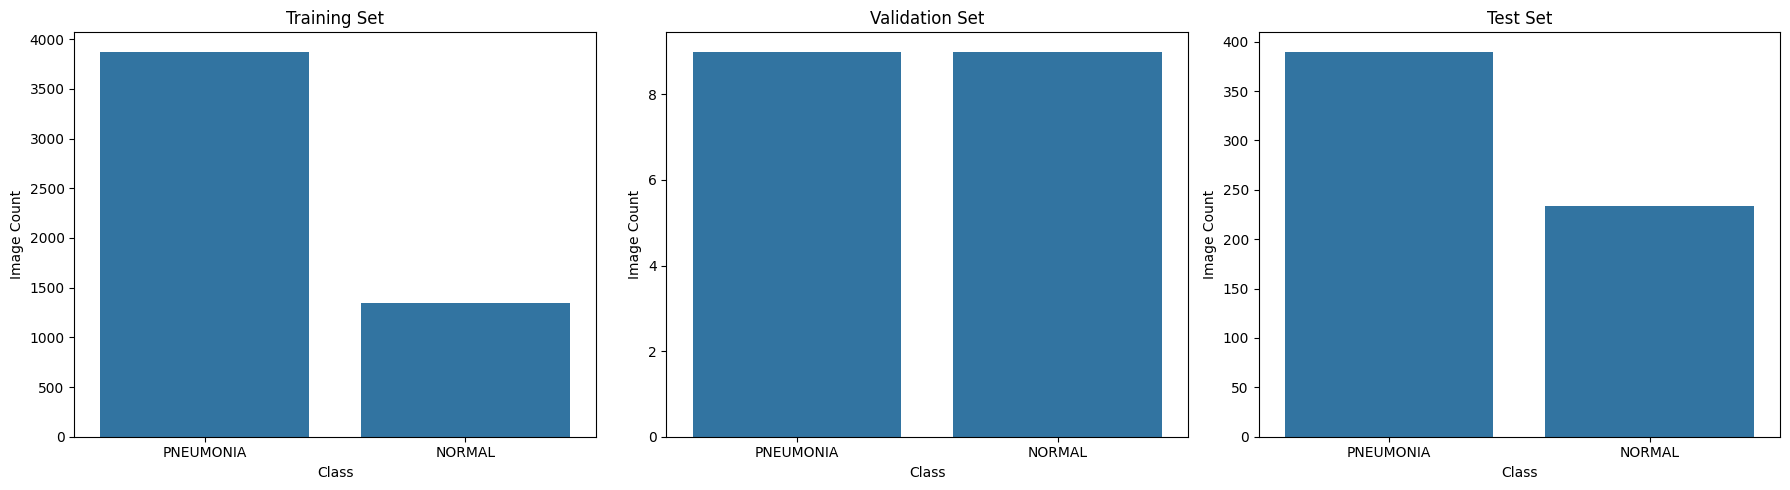

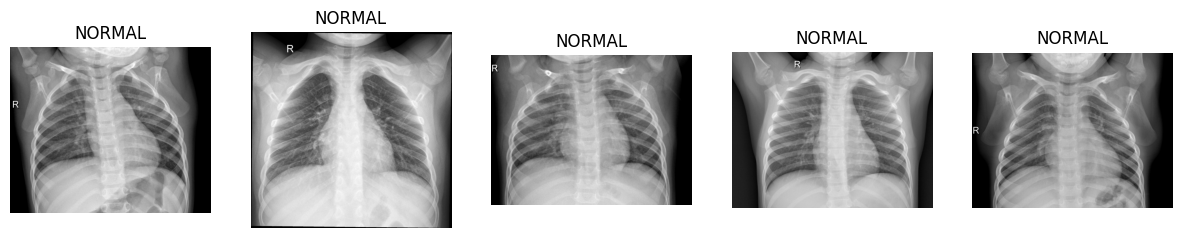

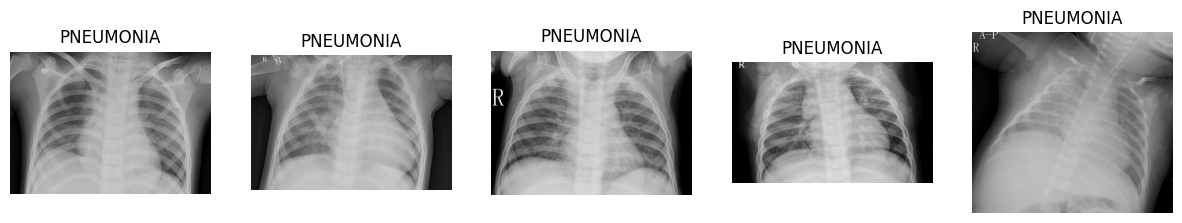

In [3]:
base_dir = './chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

def count_images(folder):
    counts = {}
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            counts[class_name] = len(os.listdir(class_folder))
    return counts

def plot_image_counts_row(folders, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (folder, title) in enumerate(zip(folders, titles)):
        counts = count_images(folder)
        sns.barplot(ax=axes[i], x=list(counts.keys()), y=list(counts.values()))
        axes[i].set_title(title)
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel('Image Count')

    plt.tight_layout()
    plt.show()

plot_image_counts_row(
    folders=[train_dir, val_dir, test_dir],
    titles=['Training Set', 'Validation Set', 'Test Set']
)

# Function to show sample images from a given folder and label
def show_sample_images(folder, label, n=5):
    files = glob(os.path.join(folder, label, '*.jpeg'))[:n]
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

show_sample_images(train_dir, 'NORMAL')
show_sample_images(train_dir, 'PNEUMONIA')

### 2.2 Data Preprocessing

In [ ]:
def process_image(filepath, label, target_size, grayscale=False):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, target_size)
    if not grayscale:
        img = np.stack([img_resized] * 3, axis=-1)
        img_normalized = img / 255.0
        return img_normalized, label
    else:
        img = img_resized
        img_normalized = img / 255.0
        img_final = np.expand_dims(img_normalized, axis=-1)  
        return img_final, label

def load_images_from_folder_parallel(folder, label, target_size=(64, 64), grayscale=False):
    filepaths = [os.path.join(folder, f) for f in os.listdir(folder)]
    images, labels = [], []

    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(lambda f: process_image(f, label, target_size, grayscale=grayscale), filepaths), total=len(filepaths)))

    for img, lbl in results:
        if img is not None:
            images.append(img)
            labels.append(lbl)

    return np.array(images), np.array(labels)

def load_dataset(base_path, target_size=(64, 64), grayscale=False):
    X, y = [], []
    class_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(base_path, label_name)
        print(f"Loading images from {path} for label '{label_name}'")
        images, labels = load_images_from_folder_parallel(path, class_map[label_name], target_size, grayscale=grayscale)
        X.append(images)
        y.append(labels)

    return np.concatenate(X), np.concatenate(y)

def augment_normal_images(normal_images, pneumonia_count, target_size=(64, 64), grayscale=False):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    needed = pneumonia_count - len(normal_images)
    if grayscale:
        reshaped = normal_images.reshape((-1, *target_size, 1))
    else:
        reshaped = normal_images.reshape((-1, *target_size, 3))

    batch_size = 32
    augmented = []
    for batch in datagen.flow(reshaped, batch_size=batch_size):
        augmented.append(batch[:min(batch_size, needed - len(augmented))])
        if len(augmented) * batch_size >= needed:
            break

    aug_images = np.concatenate(augmented)[:needed]
    return aug_images, np.zeros(len(aug_images), dtype=int)

In [ ]:
# Load and preprocess the dataset
print("Loading training data...")
X_train, y_train = load_dataset(train_dir)
print(f"Loaded {len(X_train)} training images with labels: {Counter(y_train)}")

print("Loading validation data...")
X_val, y_val = load_dataset(val_dir)
print(f"Loaded {len(X_val)} validation images with labels: {Counter(y_val)}")

print("Loading test data...")
X_test, y_test = load_dataset(test_dir)
print(f"Loaded {len(X_test)} test images with labels: {Counter(y_test)}")

counts = Counter(y_train)
print(f"Before augmentation: PNEUMONIA: {counts[1]}, NORMAL: {counts[0]}")

normal_images = X_train[y_train == 0]
pneumonia_count = counts[1]
aug_X, aug_y = augment_normal_images(normal_images, pneumonia_count)

X_train_balanced = np.concatenate([X_train, aug_X])
y_train_balanced = np.concatenate([y_train, aug_y])

print(f"After augmentation: PNEUMONIA: {Counter(y_train_balanced)[1]}, NORMAL: {Counter(y_train_balanced)[0]}")

Loading training data...
Loading images from ./chest_xray/train/NORMAL for label 'NORMAL'


  0%|          | 0/1342 [00:00<?, ?it/s]

100%|██████████| 1342/1342 [00:01<00:00, 1002.69it/s]


Loading images from ./chest_xray/train/PNEUMONIA for label 'PNEUMONIA'


100%|██████████| 3876/3876 [00:00<00:00, 4085.54it/s]


Loaded 5216 training images with labels: Counter({np.int64(1): 3875, np.int64(0): 1341})
Loading validation data...
Loading images from ./chest_xray/val/NORMAL for label 'NORMAL'


100%|██████████| 9/9 [00:00<00:00, 629.23it/s]


Loading images from ./chest_xray/val/PNEUMONIA for label 'PNEUMONIA'


100%|██████████| 9/9 [00:00<00:00, 2629.84it/s]


Loaded 16 validation images with labels: Counter({np.int64(0): 8, np.int64(1): 8})
Loading test data...
Loading images from ./chest_xray/test/NORMAL for label 'NORMAL'


100%|██████████| 234/234 [00:00<00:00, 1561.58it/s]


Loading images from ./chest_xray/test/PNEUMONIA for label 'PNEUMONIA'


100%|██████████| 390/390 [00:00<00:00, 4427.13it/s]


Loaded 624 test images with labels: Counter({np.int64(1): 390, np.int64(0): 234})
Before augmentation: PNEUMONIA: 3875, NORMAL: 1341
After augmentation: PNEUMONIA: 3875, NORMAL: 3875


Flattening images...
Flattening complete.
Training SVM with PCA...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM model saved.
Training Random Forest with PCA...
RF with PCA model saved.
Training Random Forest without PCA...
RF (raw) model saved.

--- SVM Results (with PCA) ---
              precision    recall  f1-score   support

      NORMAL       0.95      0.45      0.61       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.73       624
weighted avg       0.82      0.79      0.76       624

Accuracy: 0.7853


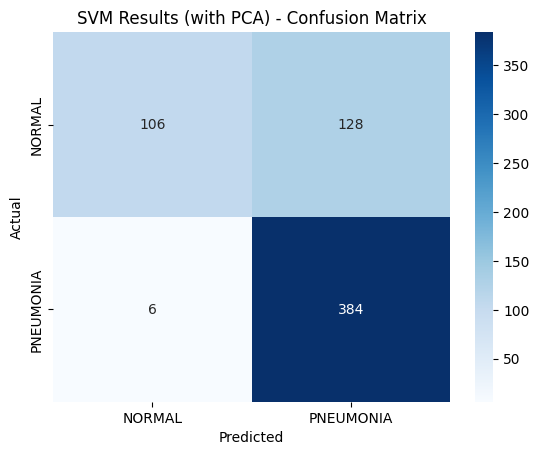


--- Random Forest Results (no PCA) ---
              precision    recall  f1-score   support

      NORMAL       0.92      0.66      0.77       234
   PNEUMONIA       0.82      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624

Accuracy: 0.8494


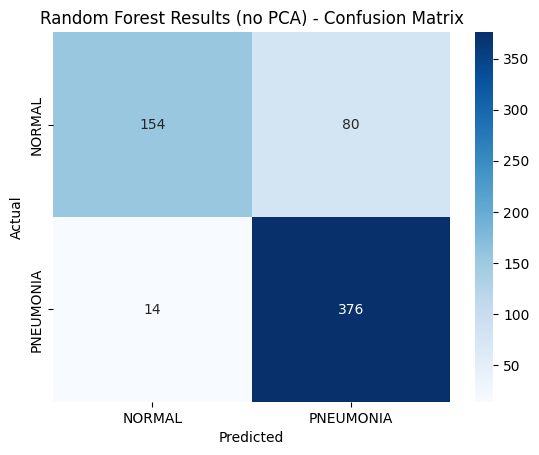


--- Random Forest Results (with PCA) ---
              precision    recall  f1-score   support

      NORMAL       0.81      0.54      0.65       234
   PNEUMONIA       0.77      0.93      0.84       390

    accuracy                           0.78       624
   macro avg       0.79      0.73      0.75       624
weighted avg       0.79      0.78      0.77       624

Accuracy: 0.7821


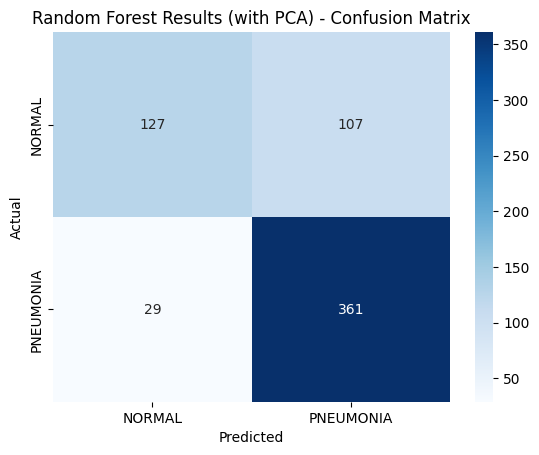

In [ ]:
# Utility: Flatten images in parallel
def fast_flatten(images):
    return np.array(
        joblib.Parallel(n_jobs=-1, prefer="threads")(joblib.delayed(lambda img: img.flatten())(img) for img in images)
    )

# Paths for models
os.makedirs("models", exist_ok=True)
svm_path = "models/best_svm_model.pkl"
rf_pca_path = "models/rf_model_pca.pkl"
rf_raw_path = "models/rf_model_raw.pkl"

# Preprocess
print("Flattening images...")
X_train_flat = fast_flatten(X_train_balanced)
X_val_flat = fast_flatten(X_val)
X_test_flat = fast_flatten(X_test)
print("Flattening complete.")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# PCA
pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 1. Support Vector Machine 
if os.path.exists(svm_path):
    print("Loading existing SVM model...")
    best_svm_model = joblib.load(svm_path)
else:
    print("Training SVM with PCA...")
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }
    grid = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted')
    grid.fit(X_train_pca, y_train_balanced)
    best_svm_model = grid.best_estimator_
    joblib.dump(best_svm_model, svm_path)
    print("SVM model saved.")

svm_preds = best_svm_model.predict(X_test_pca)

# 2. Random Forest (with PCA) 
if os.path.exists(rf_pca_path):
    print("Loading existing Random Forest (with PCA)...")
    rf_model_pca = joblib.load(rf_pca_path)
else:
    print("Training Random Forest with PCA...")
    rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model_pca.fit(X_train_pca, y_train_balanced)
    joblib.dump(rf_model_pca, rf_pca_path)
    print("RF with PCA model saved.")

rf_preds_pca = rf_model_pca.predict(X_test_pca)

# 3. Random Forest (raw, no PCA) 
if os.path.exists(rf_raw_path):
    print("Loading existing Random Forest (raw)...")
    rf_model = joblib.load(rf_raw_path)
else:
    print("Training Random Forest without PCA...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train_flat, y_train_balanced)
    joblib.dump(rf_model, rf_raw_path)
    print("RF (raw) model saved.")

rf_preds = rf_model.predict(X_test_flat)

# Evaluation Function 
def evaluate_model(y_true, y_pred, title):
    print(f"\n--- {title} ---")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print Results 
evaluate_model(y_test, svm_preds, "SVM Results (with PCA)")
evaluate_model(y_test, rf_preds, "Random Forest Results (no PCA)")
evaluate_model(y_test, rf_preds_pca, "Random Forest Results (with PCA)")


## Deep Learning Model (CNN)

Two CNN architectures are defined:
- **Simple CNN:** A basic convolutional network for quick experimentation.
- **Best CNN:** A deeper network with regularization (Dropout, BatchNorm, L2) for improved performance.

Data augmentation is also applied during training to further improve generalization.

In [ ]:
# CNN from Scratch 
def create_simple_cnn(input_shape=(64, 64, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_best_cnn(input_shape=(150, 150, 1)):
    l2_reg = 1e-4  

    model = Sequential([
        layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2), strides=2, padding='same'),

        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2), strides=2, padding='same'),

        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2), strides=2, padding='same'),

        layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2), strides=2, padding='same'),

        layers.Conv2D(256, (3, 3), strides=1, padding='same',activation='relu',kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2), strides=2, padding='same'),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(0.4),

        layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
    return model

/home/christos/Desktop/maria/image_processing/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

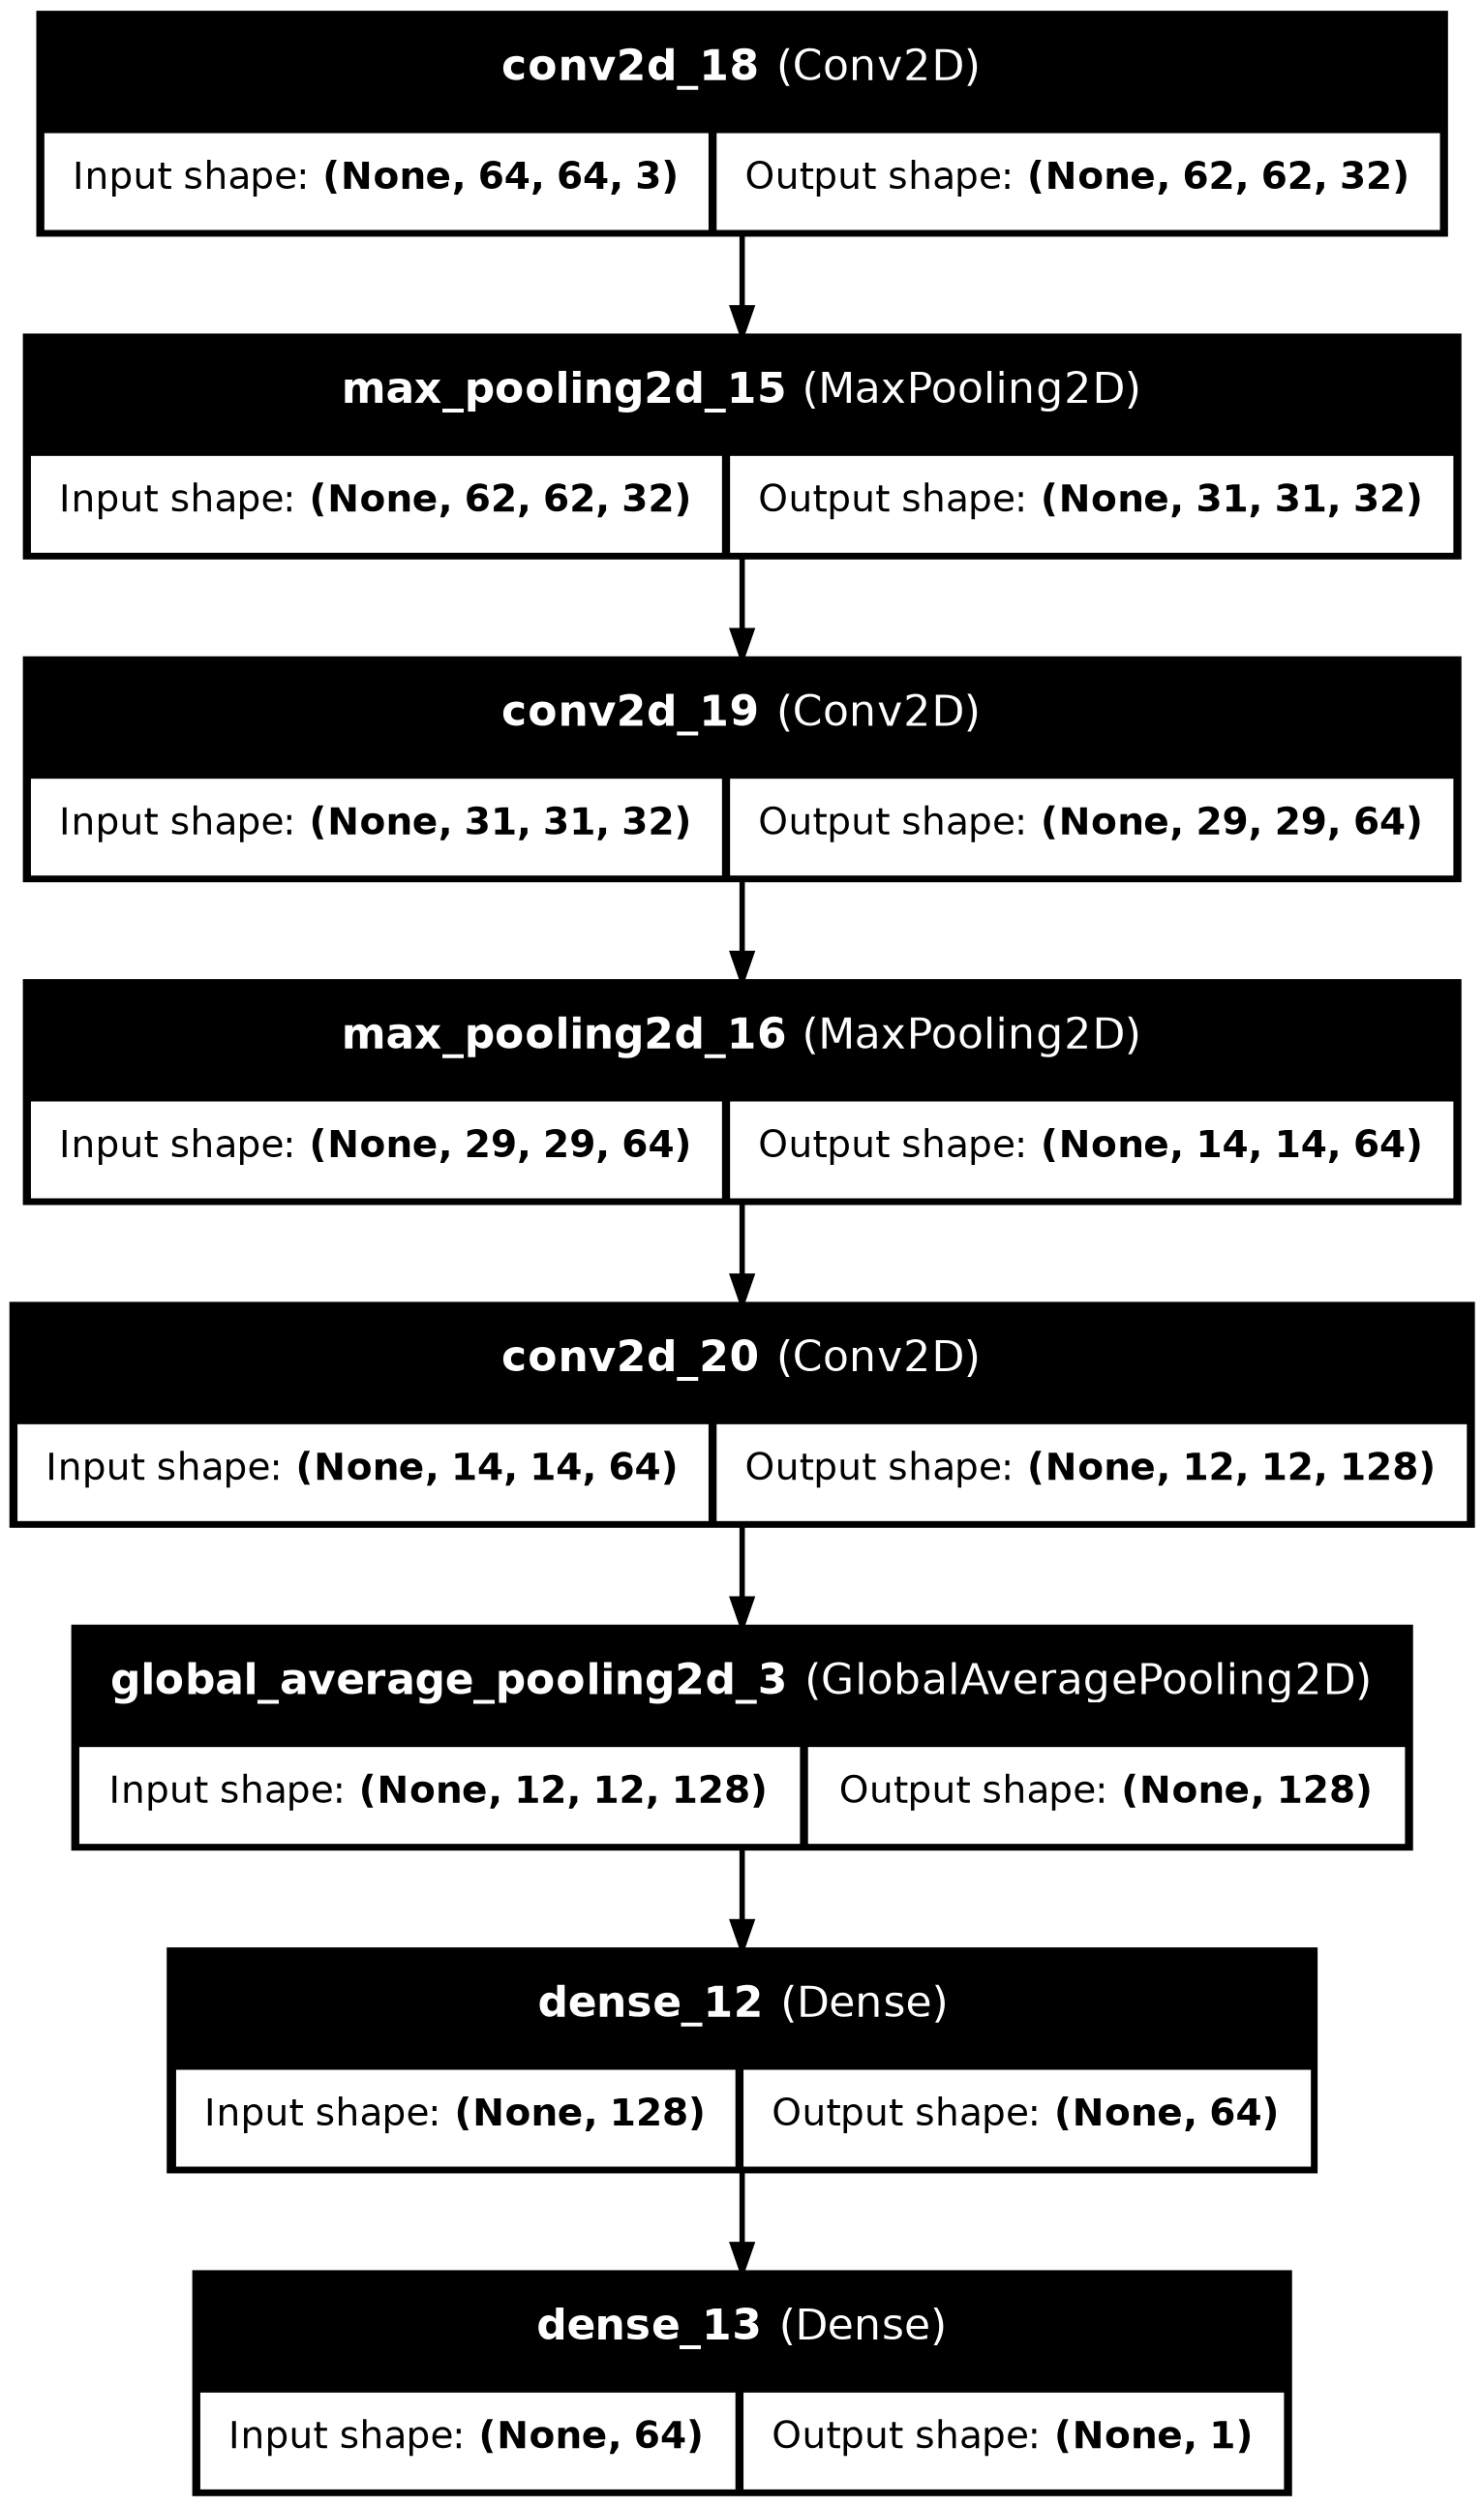

In [10]:
cnn_model = create_simple_cnn()
cnn_model.summary()
plot_model(cnn_model, show_shapes=True, show_layer_names=True, to_file='cnn_model.png')
Image(filename='cnn_model.png', width=800, height=600)

/home/christos/Desktop/maria/image_processing/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

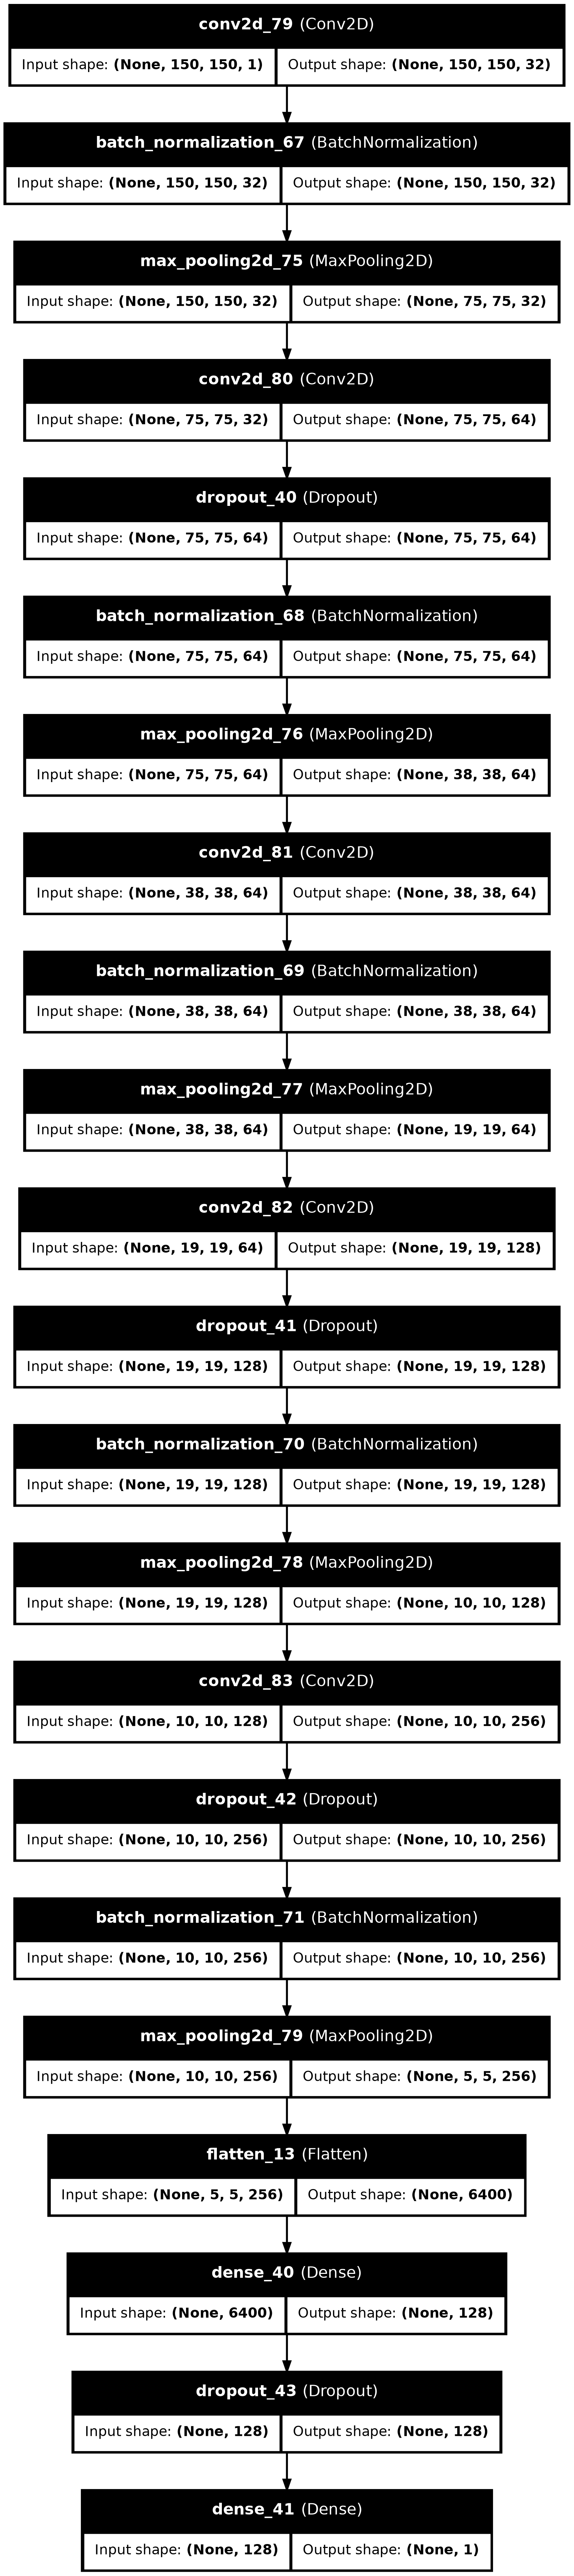

In [73]:
cnn_best_model = create_best_cnn()
cnn_best_model.summary()
plot_model(cnn_best_model, show_shapes=True, show_layer_names=True, to_file='cnn_best_model.png')
Image(filename='cnn_best_model.png', width=800, height=600)

In [ ]:
# Load and preprocess for CNN (150x150)
cnn_target_size = (150, 150)

print("Loading training data (150x150)...")
cnn_X_train, cnn_y_train = load_dataset(train_dir, target_size=cnn_target_size, grayscale=True)
print(f"Loaded {len(cnn_X_train)} training images with labels: {Counter(cnn_y_train)}")

print("Loading validation data (150x150)...")
cnn_X_val, cnn_y_val = load_dataset(val_dir, target_size=cnn_target_size, grayscale=True)
print(f"Loaded {len(cnn_X_val)} validation images with labels: {Counter(cnn_y_val)}")

print("Loading test data (150x150)...")
cnn_X_test, cnn_y_test = load_dataset(test_dir, target_size=cnn_target_size, grayscale=True)
print(f"Loaded {len(cnn_X_test)} test images with labels: {Counter(cnn_y_test)}")

cnn_counts = Counter(cnn_y_train)
print(f"Before augmentation: PNEUMONIA: {cnn_counts[1]}, NORMAL: {cnn_counts[0]}")

cnn_normal_images = cnn_X_train[cnn_y_train == 0]
cnn_pneumonia_count = cnn_counts[1]
cnn_aug_X, cnn_aug_y = augment_normal_images(cnn_normal_images, cnn_pneumonia_count, target_size=cnn_target_size, grayscale=True)

cnn_X_train_balanced = np.concatenate([cnn_X_train, cnn_aug_X])
cnn_y_train_balanced = np.concatenate([cnn_y_train, cnn_aug_y])

print(f"After augmentation: PNEUMONIA: {Counter(cnn_y_train_balanced)[1]}, NORMAL: {Counter(cnn_y_train_balanced)[0]}")

# Combine and resplit train and validation sets
X_combined = np.concatenate([cnn_X_train_balanced, cnn_X_val])
y_combined = np.concatenate([cnn_y_train_balanced, cnn_y_val])

cnn_X_train, cnn_X_val, cnn_y_train, cnn_y_val = train_test_split(X_combined, y_combined, test_size=0.15, stratify=y_combined)

Loading training data (150x150)...
Loading images from ./chest_xray/train/NORMAL for label 'NORMAL'


100%|██████████| 1342/1342 [00:01<00:00, 1067.50it/s]


Loading images from ./chest_xray/train/PNEUMONIA for label 'PNEUMONIA'


100%|██████████| 3876/3876 [00:00<00:00, 4819.91it/s]


Loaded 5216 training images with labels: Counter({np.int64(1): 3875, np.int64(0): 1341})
Loading validation data (150x150)...
Loading images from ./chest_xray/val/NORMAL for label 'NORMAL'


100%|██████████| 9/9 [00:00<00:00, 1033.70it/s]


Loading images from ./chest_xray/val/PNEUMONIA for label 'PNEUMONIA'


100%|██████████| 9/9 [00:00<00:00, 2507.56it/s]


Loaded 16 validation images with labels: Counter({np.int64(0): 8, np.int64(1): 8})
Loading test data (150x150)...
Loading images from ./chest_xray/test/NORMAL for label 'NORMAL'


100%|██████████| 234/234 [00:00<00:00, 1742.95it/s]


Loading images from ./chest_xray/test/PNEUMONIA for label 'PNEUMONIA'


100%|██████████| 390/390 [00:00<00:00, 4561.79it/s]


Loaded 624 test images with labels: Counter({np.int64(1): 390, np.int64(0): 234})
Before augmentation: PNEUMONIA: 3875, NORMAL: 1341
After augmentation: PNEUMONIA: 3875, NORMAL: 3875


In [58]:
early_stop = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

datagen = ImageDataGenerator(
    zoom_range = 0.2,                       # Randomly zoom image 
    rotation_range = 30,                    # randomly rotate images in the range (degrees, 0 to 180)
    zca_whitening=False,                    # apply ZCA whitening
    vertical_flip=False,                    # randomly flip images
    width_shift_range=0.1,                  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,                 # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,                 # randomly flip images
    samplewise_center=False,                # set each sample mean to 0
    featurewise_center=False,               # set input mean to 0 over the dataset
    samplewise_std_normalization=False,     # divide each input by its std
    featurewise_std_normalization=False,    # divide inputs by std of the dataset
)


datagen.fit(cnn_X_train)

In [ ]:
model_path = "models/cnn_model1.keras"
print("Training new CNN model...")
cnn_model = create_best_cnn()
history = cnn_model.fit(
    datagen.flow(cnn_X_train,cnn_y_train, batch_size = 32),
    epochs = 30,
    validation_data = datagen.flow(cnn_X_val, cnn_y_val),
    callbacks = [
        learning_rate_reduction,
        early_stop,
    ]
)
cnn_model.save(model_path)
print("Model saved.")

Training new CNN model...


/home/christos/Desktop/maria/image_processing/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.7565 - auc: 0.8107 - loss: 1.6046 - val_accuracy: 0.4996 - val_auc: 0.5000 - val_loss: 37.1093 - learning_rate: 0.0010
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8893 - auc: 0.9495 - loss: 0.3982 - val_accuracy: 0.4996 - val_auc: 0.5000 - val_loss: 32.4896 - learning_rate: 0.0010
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9215 - auc: 0.9750 - loss: 0.2833 - val_accuracy: 0.5021 - val_auc: 0.5026 - val_loss: 13.8764 - learning_rate: 0.0010
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9184 - auc: 0.9736 - loss: 0.2947 - val_accuracy: 0.9082 - val_auc: 0.9501 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9407 - auc: 0.9815 - loss: 0.2522 - val_accuracy: 0.5202 - val_auc: 0.9150 - val_loss: 1.0899 - learning_rate: 0.0010
Epoch 6/30
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9390

In [ ]:
def evaluate_model_on_test(model, test_data, test_labels, batch_size=32, epochs=30):
    # Predict
    y_pred_probs = model.predict(test_data, batch_size=batch_size)
    y_pred = (y_pred_probs > 0.5).astype("int32")

    # Classification report
    print("📊 Classification Report:")
    print(classification_report(test_labels, y_pred, target_names=["Normal", "Pneumonia"]))

    # Analysis
    epochs = [i for i in range(epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("CNN Confusion Matrix")
    plt.show()

    # Accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.76      0.84       234
   Pneumonia       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



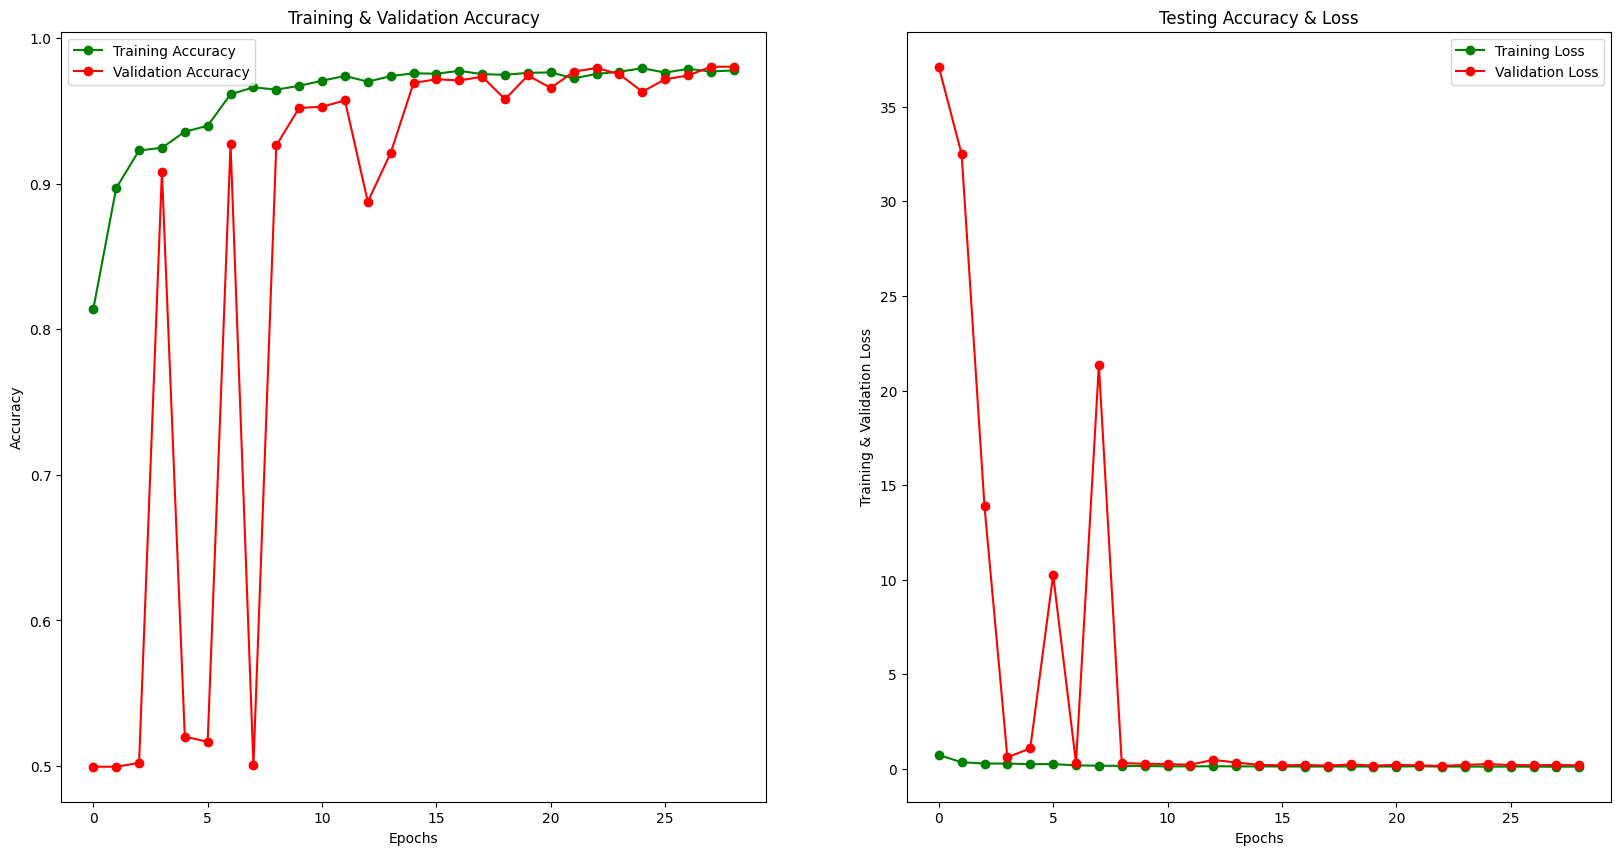

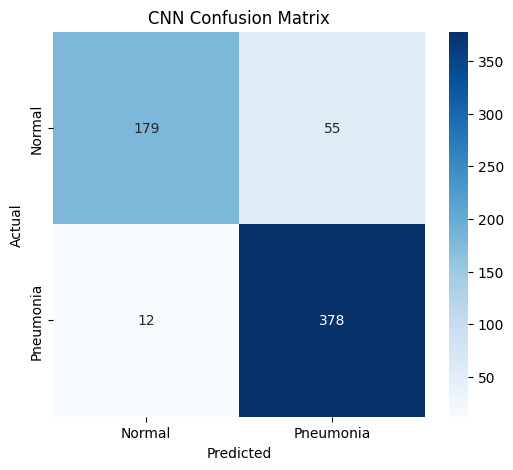

Test Accuracy: 0.8926


In [77]:
model_path = "models/cnn_model.keras"
if os.path.exists(model_path):
    cnn_model = load_model(model_path)
evaluate_model_on_test(cnn_model, cnn_X_test, cnn_y_test, epochs=29)

## Results and Discussion

### Classical ML Results
- **SVM (with PCA):**
  - The SVM model achieves reasonable accuracy and recall, especially after balancing the dataset. However, its performance is limited by the simplicity of features extracted from small images.
- **Random Forest (raw & with PCA):**
  - Random Forest performs better when trained on the raw, flattened images (no PCA) compared to PCA-reduced features. This suggests that retaining the full set of pixel features allows the Random Forest to capture more relevant patterns for classification, while PCA may discard some useful information for this model.

### CNN Results
- **Best CNN Model:**
  - The deep CNN achieves the highest accuracy and recall among all models. The use of data augmentation, regularization, and a deeper architecture allows it to learn complex features from the X-ray images, resulting in strong performance on the test set.
- **Confusion Matrix & Classification Report:**
  - The confusion matrix and classification report show that the CNN is effective at distinguishing between normal and pneumonia cases, with high precision and recall for both classes.

### Conclusion
- Balancing the dataset using data augmentation was crucial for improving model performance, especially for the minority class (normal).
- Deep learning models (CNNs) significantly outperform classical ML models on this image classification task, thanks to their ability to learn hierarchical features.
- Further improvements could include using transfer learning with pre-trained models, more advanced augmentation, or ensembling multiple models.
